<a href="https://colab.research.google.com/github/milver/Experiments/blob/main/Barometric_Pressure.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Barometric Pressure Ecxtraction

In [24]:
import requests
from datetime import datetime, timedelta
import pytz
import matplotlib.pyplot as plt
import numpy as np

In [25]:
# Function to fetch data from the API
def fetch_data(url):
    response = requests.get(url)
    if response.status_code == 200:
        return response.json()
    else:
        print("Failed to fetch data")
        return None



In [26]:
# Process the data assuming it's in Eastern Daylight Time (EDT)
def process_data(json_data, start_time, end_time):
    edt_tz = pytz.timezone('America/New_York')

    processed_data = []
    for record in json_data["historyData"]:
        edt_time = datetime.fromisoformat(record["startTime"].replace("Z", "+00:00")).astimezone(edt_tz)
        if start_time <= edt_time <= end_time:
            pressure_inhg = record["values"]["pressureSeaLevel"]
            pressure_mbar = pressure_inhg * 33.8639
            processed_data.append({
                "startTime": edt_time.strftime("%Y-%m-%dT%H:%M:%S"),
                "pressureSeaLevel_mbar": pressure_mbar
            })

    return processed_data


In [29]:
# Updated function to find entry and exit points of the migraine zone
def find_migraine_zone_entries(pressures, times):
    zone_limits = [1003, 1007]
    entries_and_exits = {limit: [] for limit in zone_limits}

    for i in range(len(pressures) - 1):
        current_pressure = pressures[i]
        next_pressure = pressures[i + 1]
        current_time = times[i]
        next_time = times[i + 1]
        for limit in zone_limits:
            if (current_pressure < limit and next_pressure >= limit) or (current_pressure > limit and next_pressure <= limit):
                # Calculate the interpolated time
                delta_t = (limit - current_pressure) / (next_pressure - current_pressure)
                interpolated_time = current_time + (next_time - current_time) * delta_t
                entries_and_exits[limit].append(interpolated_time)

    return entries_and_exits


In [30]:
# Updated plotting function with migraine zone entry and exit highlighting
def plot_data(processed_data, file_path):
    times = [datetime.fromisoformat(d['startTime']) for d in processed_data]
    pressures = [d['pressureSeaLevel_mbar'] for d in processed_data]

    entries_and_exits = find_migraine_zone_entries(pressures, times)

    plt.figure(figsize=(12, 7))
    plt.plot(times, pressures, marker='o', linestyle='-')
    plt.title('Pressure vs. Time with Migraine Zone Highlighted')
    plt.xlabel('Time')
    plt.ylabel('Pressure (mbar)')
    plt.grid(True)

    # Highlighting the migraine zone between 1003 and 1007 mbar
    plt.fill_between(times, 1003, 1007, color='red', alpha=0.2)

    # Plot entry and exit points
    for limit, moments in entries_and_exits.items():
        for moment in moments:
            plt.axvline(x=moment, color='blue', linestyle='--')
            plt.text(moment, limit, moment.strftime('%a %-I%p'), fontsize=9, ha='right')

    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig(file_path)
    plt.show()

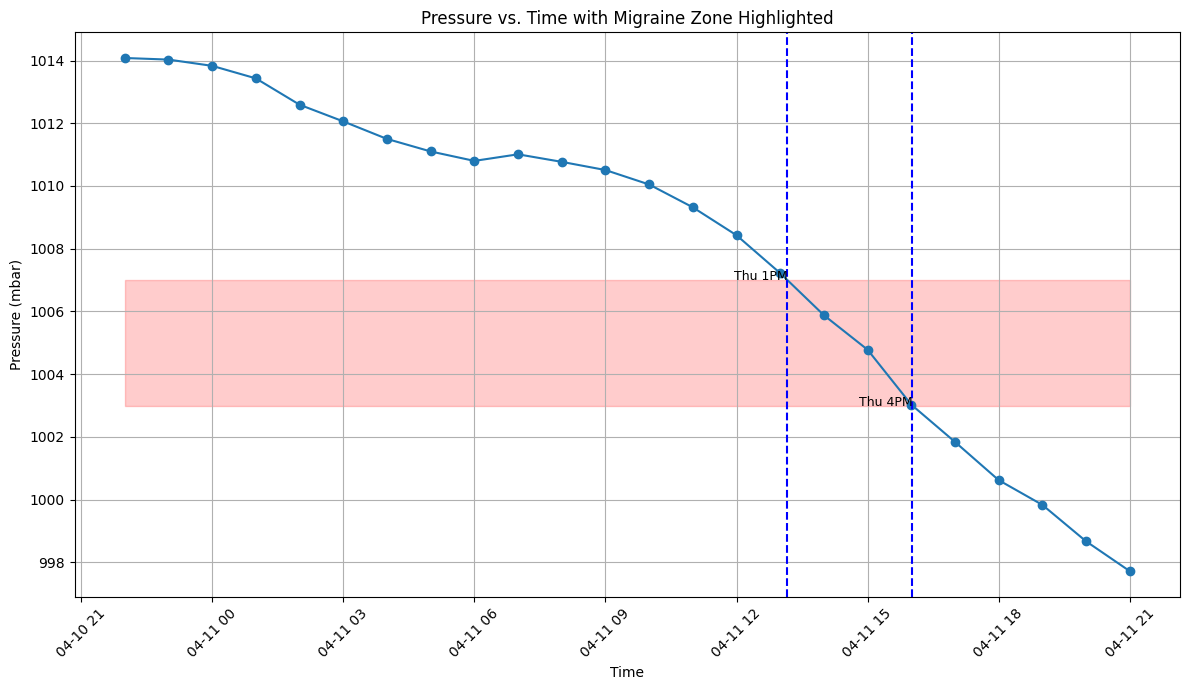

In [31]:
# Final section to run everything
def main():
    url = 'https://barometricpressure.app/api/timelineWk?lat=39.020834&lng=-77.50411'
    json_data = fetch_data(url)
    if json_data:
        edt_tz = pytz.timezone('America/New_York')
        current_time = datetime.now(edt_tz)
        start_time_input = current_time - timedelta(hours=24)
        end_time_input = current_time
        processed_data = process_data(json_data, start_time_input, end_time_input)
        plot_data(processed_data, 'pressure_time_chart.png')

main()